In [1]:
import biom
import pandas as pd
import glob

from birdman import NegativeBinomial

In [6]:
import cmdstanpy
cmdstanpy.install_cmdstan()

CmdStan install directory: /Users/candusshi/.cmdstan
Installing CmdStan version: 2.36.0
Download successful, file: /var/folders/hc/mnggsfz56v305wwb48gk6cjm0000gp/T/tmpboei4ezc
Extracting distribution
Unpacked download as cmdstan-2.36.0
Building version cmdstan-2.36.0, may take several minutes, depending on your system.
Installed cmdstan-2.36.0
Test model compilation


True

In [2]:
fpath = glob.glob("templates/*.txt")[0]
table = biom.load_table("BIOM/44773/otu_table.biom")
metadata = pd.read_csv(
    fpath,
    sep="\t",
    index_col=0
)

metadata.head()

,adiponectin,anonymized_name,b_cell_function_measure,body_weight,cd11c,collection_date,country,depth,description,diet,...,scientific_name,slc25a,t3,t4,taxon_id,title,tnfa,total_ee,total_number_of_synapses,treatment
sample_name,,,,,,,,,,,,,,,,,,,,,
107.CM01,44.03,sample01,154.5,30.6,0.60,11/8/11,GAZ:United States of America,0,The gut microbiome of weight reduced and ad li...,DIO,...,mouse gut metagenome,0.85,72.86,45.06,410661,Leptin levels correlate with the composition o...,1.51,10.60,23.29,Weight Reduced
107.CM02,44.16,sample09,200.6,52.0,1.86,11/8/11,GAZ:United States of America,0,The gut microbiome of weight reduced and ad li...,DIO,...,mouse gut metagenome,1.07,13.60,33.96,410661,Leptin levels correlate with the composition o...,1.30,13.80,NaN,Ad Lib
107.CM03,39.17,sample02,133.3,29.3,1.01,11/8/11,GAZ:United States of America,0,The gut microbiome of weight reduced and ad li...,DIO,...,mouse gut metagenome,1.14,7.76,45.12,410661,Leptin levels correlate with the composition o...,1.82,10.23,18.40,Weight Reduced
107.CM04,23.55,sample03,280.7,36.1,0.53,11/8/11,GAZ:United States of America,0,The gut microbiome of weight reduced and ad li...,DIO,...,mouse gut metagenome,1.01,15.30,57.87,410661,Leptin levels correlate with the composition o...,1.17,11.70,19.06,Weight Reduced
107.CM05,28.33,sample10,472.9,52.9,1.14,11/8/11,GAZ:United States of America,0,The gut microbiome of weight reduced and ad li...,DIO,...,mouse gut metagenome,1.55,33.46,52.03,410661,Leptin levels correlate with the composition o...,0.62,16.06,26.44,Ad Lib


In [36]:
table

1932 x 29 <class 'biom.table.Table'> with 9055 nonzero entries (16% dense)

In [ ]:
metadat

In [3]:
prevalence = table.to_dataframe().clip(upper=1).sum(axis=1)
features_to_keep = prevalence[prevalence >= 5].index.tolist()
table_filt = table.filter(features_to_keep, axis="observation")

In [4]:
nb = NegativeBinomial(
    table=table_filt,
    formula="diet",
    metadata=metadata,
)

In [5]:
nb.compile_model()
nb.fit_model(method="vi", num_draws=500)

13:01:29 - cmdstanpy - WARNING - Argument name `output_samples` is deprecated, please rename to `draws`.
13:01:29 - cmdstanpy - INFO - Chain [1] start processing
13:03:01 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
inference = nb.to_inference()
inference

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> observed_data

In [11]:
metadata['diet']

sample_name
107.CM01        DIO
107.CM02        DIO
107.CM03        DIO
107.CM04        DIO
107.CM05        DIO
107.CM06        DIO
107.CM07        DIO
107.CM08        DIO
107.CM09        DIO
107.CM10        DIO
107.CM11        DIO
107.CM13        DIO
107.CM14        DIO
107.CM15        DIO
107.CM16        DIO
107.CM17    Control
107.CM18    Control
107.CM19    Control
107.CM20    Control
107.CM21    Control
107.CM22    Control
107.CM23    Control
107.CM24    Control
107.CM25    Control
107.CM26    Control
107.CM27    Control
107.CM28    Control
107.CM29    Control
107.CM30    Control
107.CM31    Control
107.CM32    Control
Name: diet, dtype: object

In [17]:
inference.posterior['covariate'][1].to_numpy()

array('diet[T.DIO]', dtype='<U11')

In [15]:
inference.posterior

<xarray.Dataset> Size: 7MB
Dimensions:      (covariate: 2, feature_alr: 617, draw: 500, chain: 1,
                  feature: 618)
Coordinates:
  * covariate    (covariate) object 16B 'Intercept' 'diet[T.DIO]'
  * feature_alr  (feature_alr) <U7 17kB '276620' '262101' ... '192368' '192365'
  * draw         (draw) int64 4kB 0 1 2 3 4 5 6 ... 493 494 495 496 497 498 499
  * chain        (chain) int64 8B 0
  * feature      (feature) <U7 17kB '206494' '276620' ... '192368' '192365'
Data variables:
    beta_var     (chain, draw, covariate, feature_alr) float64 5MB -10.86 ......
    inv_disp     (chain, draw, feature) float64 2MB 16.36 1.597 ... 0.5936 1.862

In [14]:
for i, clr in inference.posterior['beta_var'].groupby('chain'):
    print(clr.shape)

(1, 500, 2, 617)


In [8]:
from birdman.transform import posterior_alr_to_clr

inference = nb.to_inference()
inference.posterior = posterior_alr_to_clr(
    inference.posterior,
    alr_params=["beta_var"],  # the default NB model has only beta in ALR coordinates
    dim_replacement={"feature_alr": "feature"},  # the default NB model assigns 'feature_alr' as the dimension name
    new_labels=nb.feature_names  # replace the old labels (all the feature names except the first) with all the feature names
)

ValueError: too many values to unpack (expected 3)

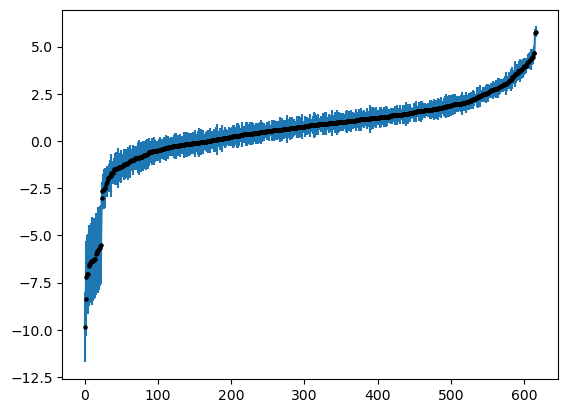

In [16]:
import birdman.visualization as viz

ax = viz.plot_parameter_estimates(
    inference,
    parameter="beta_var",
    coords={"covariate": "diet[T.DIO]"},
)

# Sam's data

In [22]:
import os
os.getcwd()

'/home/cys226/private/Causal-Discovery-on-Gut-Microbial-Data-for-Disease-Risk-Prediction/notebooks'

In [2]:
# fpath = "/Users/candusshi/academics/qiime2-capstone/metadata_2024Feb02.tsv"
fpath = "/home/cys226/private/birdman/metadata_2024Feb02.tsv"
# table = biom.load_table("/Users/candusshi/academics/qiime2-capstone/feature-table/feature-table.biom")
table = biom.load_table("/home/cys226/private/birdman/feature-table.biom")
metadata = pd.read_csv(
    fpath,
    sep="\t",
    index_col=0
)

metadata

,Phylum,Class,Order,Family,Genus,Species,Diet,Notes,Study,Primer,...,Initials,Age,Age2,Sex,Disease,City,Accession,Continent,Disease_Type,HDI_Category
sampleid,,,,,,,,,,,,,,,,,,,,,
AguileraMascardi1,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,NaN,Aguilera_et_al_2022,V3-V4,...,NS,Adult,Adult,Both,Healthy,Buenos Aires,PRJNA763205,South America,Healthy,very high
AguileraMascardi2,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,NaN,Aguilera_et_al_2022,V3-V4,...,NS,Adult,Adult,Both,Healthy,Buenos Aires,PRJNA763205,South America,Healthy,very high
AguileraMascardi3,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,NaN,Aguilera_et_al_2022,V3-V4,...,NS,Adult,Adult,Both,Healthy,Buenos Aires,PRJNA763205,South America,Healthy,very high
AguileraMascardi4,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,NaN,Aguilera_et_al_2022,V3-V4,...,NS,Adult,Adult,Both,Healthy,Buenos Aires,PRJNA763205,South America,Healthy,very high
AguileraMascardi5,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,NaN,Aguilera_et_al_2022,V3-V4,...,NS,Adult,Adult,Both,Healthy,Buenos Aires,PRJNA763205,South America,Healthy,very high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HoangLe10,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,NaN,HoangLe_et_al_2021,V3-V4,...,NT-DW,Adult,Adult,Female,Type_II_Diabetes,Hanoi,PRJNA668251,Asia,Metabolic,high
HoangLe11,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,NaN,HoangLe_et_al_2021,V3-V4,...,NT-DW,Adult,Adult,Female,Type_II_Diabetes,Hanoi,PRJNA668251,Asia,Metabolic,high
HoangLe12,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,NaN,HoangLe_et_al_2021,V3-V4,...,NT-DW,Adult,Adult,Female,Type_II_Diabetes,Hanoi,PRJNA668251,Asia,Metabolic,high


In [4]:
metadata[(metadata['Primer'] == 'V4') & (metadata['Age'] == 'Adult')]

,Phylum,Class,Order,Family,Genus,Species,Diet,Notes,Study,Primer,...,Initials,Age,Age2,Sex,Disease,City,Accession,Continent,Disease_Type,HDI_Category
sampleid,,,,,,,,,,,,,,,,,,,,,
Ang1,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Participants were white or east asian,ang_et_al_2021,V4,...,ES,Adult,Adult,Both,Healthy,San Francisco,PRJNA665061,North America,Healthy,very high
Ang2,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Participants were white or east asian,ang_et_al_2021,V4,...,ES,Adult,Adult,Both,Healthy,San Francisco,PRJNA665061,North America,Healthy,very high
Ang3,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Participants were white or east asian,ang_et_al_2021,V4,...,ES,Adult,Adult,Both,Healthy,San Francisco,PRJNA665061,North America,Healthy,very high
Ang4,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Participants were white or east asian,ang_et_al_2021,V4,...,ES,Adult,Adult,Both,Healthy,San Francisco,PRJNA665061,North America,Healthy,very high
Ang5,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Participants were white or east asian,ang_et_al_2021,V4,...,ES,Adult,Adult,Both,Healthy,San Francisco,PRJNA665061,North America,Healthy,very high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sankaranarayanan25,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Native Cheyenne and Arapaho in Oklahoma,sankaranarayanan_et_al_2015,V4,...,ES,Adult,Adult,Both,Healthy,"Clinton, Concho, Geary, Hammon, Kingfisher",PRJNA268964,North America,Healthy,very high
Sankaranarayanan26,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Native Cheyenne and Arapaho in Oklahoma,sankaranarayanan_et_al_2015,V4,...,ES,Adult,Adult,Both,Healthy,"Clinton, Concho, Geary, Hammon, Kingfisher",PRJNA268964,North America,Healthy,very high
Sankaranarayanan27,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Native Cheyenne and Arapaho in Oklahoma,sankaranarayanan_et_al_2015,V4,...,ES,Adult,Adult,Both,Healthy,"Clinton, Concho, Geary, Hammon, Kingfisher",PRJNA268964,North America,Healthy,very high


In [5]:
metadata['Primer'].value_counts()

Primer
V3-V4    1125
V4        757
V3          1
Name: count, dtype: int64

In [6]:
metadata['Age'].value_counts()

Age
Adult    1449
Child     375
Both       59
Name: count, dtype: int64

In [7]:
metadata['Age2'].value_counts()

Age2
Adult         1449
Preschool      263
Postschool      82
Both            59
Child           30
Name: count, dtype: int64

In [15]:
# default: prevalence >= 5
# for the sake of running the model, prevalence >= 100

prevalence = table.to_dataframe().clip(upper=1).sum(axis=1)
features_to_keep = prevalence[prevalence >= 100].index.tolist()
table_filt = table.filter(features_to_keep, axis="observation")

In [16]:
table.to_dataframe()

,Ang13,Ang16,Ang19,Ang10,Ang14,Ang1,Ang11,Ang15,Ang17,Ang12,...,Sankaranarayanan4,Sankaranarayanan29,Sankaranarayanan5,Sankaranarayanan26,Sankaranarayanan28,Sankaranarayanan2,Sankaranarayanan6,Sankaranarayanan7,Sankaranarayanan9,Sankaranarayanan8
010f0ac2691bc0be12d0633d4b5d2cc4,0,0,0,0,0,0,0,0,0,0,...,274.0,147.0,0,2058.0,18.0,210.0,0,0,74.0,0
04195686f2b70585790ec75320de0d6f,0,0,0,0,0,0,0,0,0,0,...,5.0,70.0,0,20.0,0,16.0,189.0,115.0,0,19.0
04c8be5a3a6ba2d70446812e99318905,0,0,0,0,0,0,0,0,0,0,...,4.0,4.0,2.0,36.0,30.0,0,0,0,0,0
059c8f8bb468064b134ea6d3661761ea,0,0,0,0,0,0,0,0,0,0,...,0,4.0,0,413.0,9.0,15.0,0,0,17.0,0
0ac7d4cacbb81c9c8182426c988a1c21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f7686a74ca2d3729eb66305e8a26309b,0,0,0,0,0,0,0,0,0,0,...,319.0,93.0,413.0,440.0,219.0,41.0,768.0,701.0,107.0,503.0
f7962a90f4519ec1d1a9c7b8ef7bf396,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,18.0,0,0,0,0
fdb1c35a8dab336d65ed22d796e71e4b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4.0,0,0,0,0
fe2a1f2b6f247658881254d63fd68b74,0,0,0,0,0,0,0,0,0,0,...,327.0,127.0,42.0,726.0,489.0,0,1965.0,0,0,1018.0


In [17]:
table_filt

205 x 455 <class 'biom.table.Table'> with 32354 nonzero entries (34% dense)

In [20]:
# remove unnecessary metadata
short_meta = metadata.loc[table.to_dataframe().columns]
short_meta

,Phylum,Class,Order,Family,Genus,Species,Diet,Notes,Study,Primer,...,Initials,Age,Age2,Sex,Disease,City,Accession,Continent,Disease_Type,HDI_Category
Ang13,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Participants were white or east asian,ang_et_al_2021,V4,...,ES,Adult,Adult,Both,Healthy,San Francisco,PRJNA665061,North America,Healthy,very high
Ang16,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Participants were white or east asian,ang_et_al_2021,V4,...,ES,Adult,Adult,Both,Healthy,San Francisco,PRJNA665061,North America,Healthy,very high
Ang19,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Participants were white or east asian,ang_et_al_2021,V4,...,ES,Adult,Adult,Both,Healthy,San Francisco,PRJNA665061,North America,Healthy,very high
Ang10,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Participants were white or east asian,ang_et_al_2021,V4,...,ES,Adult,Adult,Both,Healthy,San Francisco,PRJNA665061,North America,Healthy,very high
Ang14,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Participants were white or east asian,ang_et_al_2021,V4,...,ES,Adult,Adult,Both,Healthy,San Francisco,PRJNA665061,North America,Healthy,very high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sankaranarayanan2,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Native Cheyenne and Arapaho in Oklahoma,sankaranarayanan_et_al_2015,V4,...,ES,Adult,Adult,Both,Healthy,"Clinton, Concho, Geary, Hammon, Kingfisher",PRJNA268964,North America,Healthy,very high
Sankaranarayanan6,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Native Cheyenne and Arapaho in Oklahoma,sankaranarayanan_et_al_2015,V4,...,ES,Adult,Adult,Both,Healthy,"Clinton, Concho, Geary, Hammon, Kingfisher",PRJNA268964,North America,Healthy,very high
Sankaranarayanan7,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Native Cheyenne and Arapaho in Oklahoma,sankaranarayanan_et_al_2015,V4,...,ES,Adult,Adult,Both,Healthy,"Clinton, Concho, Geary, Hammon, Kingfisher",PRJNA268964,North America,Healthy,very high
Sankaranarayanan9,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Native Cheyenne and Arapaho in Oklahoma,sankaranarayanan_et_al_2015,V4,...,ES,Adult,Adult,Both,Healthy,"Clinton, Concho, Geary, Hammon, Kingfisher",PRJNA268964,North America,Healthy,very high


In [29]:
# two cohorts: Disease_Type (Healthy vs Metabolic)
short_meta = short_meta[(short_meta['Disease_Type'] == 'Healthy') | (short_meta['Disease_Type'] == 'Metabolic')]
short_meta

,Phylum,Class,Order,Family,Genus,Species,Diet,Notes,Study,Primer,...,Initials,Age,Age2,Sex,Disease,City,Accession,Continent,Disease_Type,HDI_Category
Ang13,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Participants were white or east asian,ang_et_al_2021,V4,...,ES,Adult,Adult,Both,Healthy,San Francisco,PRJNA665061,North America,Healthy,very high
Ang16,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Participants were white or east asian,ang_et_al_2021,V4,...,ES,Adult,Adult,Both,Healthy,San Francisco,PRJNA665061,North America,Healthy,very high
Ang19,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Participants were white or east asian,ang_et_al_2021,V4,...,ES,Adult,Adult,Both,Healthy,San Francisco,PRJNA665061,North America,Healthy,very high
Ang10,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Participants were white or east asian,ang_et_al_2021,V4,...,ES,Adult,Adult,Both,Healthy,San Francisco,PRJNA665061,North America,Healthy,very high
Ang14,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Participants were white or east asian,ang_et_al_2021,V4,...,ES,Adult,Adult,Both,Healthy,San Francisco,PRJNA665061,North America,Healthy,very high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sankaranarayanan2,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Native Cheyenne and Arapaho in Oklahoma,sankaranarayanan_et_al_2015,V4,...,ES,Adult,Adult,Both,Healthy,"Clinton, Concho, Geary, Hammon, Kingfisher",PRJNA268964,North America,Healthy,very high
Sankaranarayanan6,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Native Cheyenne and Arapaho in Oklahoma,sankaranarayanan_et_al_2015,V4,...,ES,Adult,Adult,Both,Healthy,"Clinton, Concho, Geary, Hammon, Kingfisher",PRJNA268964,North America,Healthy,very high
Sankaranarayanan7,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Native Cheyenne and Arapaho in Oklahoma,sankaranarayanan_et_al_2015,V4,...,ES,Adult,Adult,Both,Healthy,"Clinton, Concho, Geary, Hammon, Kingfisher",PRJNA268964,North America,Healthy,very high
Sankaranarayanan9,Chordata,Mammalia,Primates,Hominidae,Homo,Homo_Sapiens,Omnivore,Native Cheyenne and Arapaho in Oklahoma,sankaranarayanan_et_al_2015,V4,...,ES,Adult,Adult,Both,Healthy,"Clinton, Concho, Geary, Hammon, Kingfisher",PRJNA268964,North America,Healthy,very high


In [30]:
# remove non-healthy, non-metabolic samples from otu table
table_filt = table_filt.filter(short_meta.index.tolist())

In [33]:
nb = NegativeBinomial(
    table=table_filt,
    formula="Disease_Type",
    metadata=short_meta
    # metadata=metadata,
)

In [ ]:
nb.compile_model()
nb.fit_model(method="vi", num_draws=500)

12:30:33 - cmdstanpy - WARNING - Argument name `output_samples` is deprecated, please rename to `draws`.
12:30:33 - cmdstanpy - INFO - Chain [1] start processing
12:38:16 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
inference = nb.to_inference()

In [ ]:
inference

In [ ]:
ax = viz.plot_parameter_estimates(
    inference,
    parameter="beta_var",
    coords={"covariate": "diet[T.DIO]"},
)